# The Kepler-223 resonant chain system

Kepler-223 is a 4-planet resonant chain discovered by the *Kepler* mission. The system has been characterized via TTV analysis by [Mills et. al. 2016](https://ui.adsabs.harvard.edu/abs/2016Natur.533..509M/abstract). 
The planet's periods are locked in/near a 3:4:6:8 commensurability. [Delisle (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..96D/abstract)
describes an analytic model for the resonant dynamics of this (and similar) systems. This example is based on  this analytic model.

We'll proceed through a series of canonical transformations to arrive at a Hamiltonian model for the resonant interactions in this system. We'll then use this model to solve for the families of equilibrium configurations for this resonant chain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import rebound as rb
from celmech import get_symbol, get_symbol0

## Set up a `rebound` simulation of Kepler-223

First we'll set up a `rebound` simulation of the Kepler-223 system, initializing each planet at its observed best-fit mass and orbital period. We won't worry about setting eccentricities our orbital phases now, since we'll be determining these later when we solve for resonant equilibrium configurations.

In [2]:
# Taken from Table 1 of Mills+ (2016)
Mstar = 1.125
Mearth = 3e-6

periods = [7.38449,9.84564,14.78869,19.72567] # Periods in days
masses = [7.4,5.1,8.0,4.8] # Masses in Earth masses


sim = rb.Simulation()
sim.units  = ("Msun","days","AU")
sim.add(m=Mstar)
for mass,per in zip(masses,periods):
    sim.add(m = mass*Mearth,P =per)
sim.move_to_com()

## Set up a `PoincareHamiltonian` object

We'll use the `PoincareHamiltonian` class to begin constructing an analytic model for the system.

In [3]:
from celmech import Poincare,PoincareHamiltonian

In [4]:
pvars = Poincare.from_Simulation(sim)
pham = PoincareHamiltonian(pvars)

### Add resonant interaction terms: 
First, we determine nearest $j$:$j-1$ for each adjacent resonant pair, then add the corresponding resonant interaction terms for each pair. Finally, we add the additional 2:1 MMR terms for the non-adjacent planets.

In [5]:
max_order = 1 # Include terms up to 1st order in e
add_secular = False # We won't include secular terms
p_arr=np.array(periods) 
# the nearest j:j-1 resonance is given by j= Round[ 1+1/((P_out/P_in) - 1) ]
res_list = np.round(1+1/(p_arr[1:]/p_arr[:-1]-1)).astype(int)

# Add secular terms
if add_secular:
    for i in range(1,pham.N):
        for j in range(i+1,pham.N):
            pham.add_monomial_term([0 for _ in range(6)],(0,0,1,0),indexIn=i,indexOut=j)
            pham.add_monomial_term([0 for _ in range(6)],(0,0,0,1),indexIn=i,indexOut=j)
            pham.add_monomial_term([0,0,-1,1,0,0],(0,0,0,0),indexIn=i,indexOut=j)
        
# Add adjacent pair terms
for i,j in enumerate(res_list):
    pham.add_MMR_terms(j,1,max_order,indexIn=i+1,indexOut=i+2,inclinations=False)

    
# add the 2:1 MMR terms for non-adjacent pairs
pham.add_MMR_terms(2,1,max_order,indexIn=2,indexOut=4,inclinations=False)
pham.add_MMR_terms(2,1,max_order,indexIn=1,indexOut=3,inclinations=False)

# Transformation to resonant variables

Following Equation 12 of [Delisle (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..96D/abstract), we perform a canonical transformation to new resonant angle variables[^1].  

$$
\begin{pmatrix}
\phi_1\\
\phi_2\\
\phi_3\\
\phi_4\\\
s_1\\
s_2\\
s_3\\
s_4
\end{pmatrix}
= 
\underbrace{
\begin{pmatrix}
    1 & -2 &  1 &  0     & 0 & 0 & 0 & 0 \\
    0 &  1 & -3 &  2     & 0 & 0 & 0 & 0 \\
    0 &  0 &  1 & -1     & 0 & 0 & 0 & 0 \\
    0 &  0 & -3 &  4     & 0 & 0 & 0 & 0 \\    
    0 &  0 & -3 &  4     & 1 & 0 & 0 & 0 \\
    0 &  0 & -3 &  4     & 0 & 1 & 0 & 0 \\
    0 &  0 & -3 &  4     & 0 & 0 & 1 & 0 \\
    0 &  0 & -3 &  4     & 0 & 0 & 0 & 1 
\end{pmatrix}}_{A}
\cdot
\begin{pmatrix}
\lambda_1\\
\lambda_2\\
\lambda_3\\
\lambda_4\\
\gamma_1\\
\gamma_2\\
\gamma_3\\
\gamma_4
\end{pmatrix}
$$
along with conjugate momenta $(\Phi_1,...,\Phi_4,D_1,...,D_4) = [A^{-1}]^{\mathrm{tr}} \cdot (\Lambda_1,...,\Lambda_4,\Gamma_1,...,\Gamma_4)$. We also introduce $\psi_i = \phi_i - \gamma_i+q_i$ with conjugate momenta $Q_i$ so that inclination resonance terms could be analyzed as well, though we will not consider them in this example.

[^1]: [Delisle (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..96D/abstract) uses the notation $\sigma_i$ for the angles we have termed $s_i$ conjugate to the momenta $D_i$. We adopt $s_i$ to avoid confusion with the default `Poincare` variables $\sigma_i=\sqrt{2Q_i}\cos q_i$

### Set up the transformation matrix above, with diagonal elements for the $\Omega$ angles corresponding to the non-planar degrees of freedom

In [6]:
from sympy import symbols
# Equation 12 of Delisle 2017 

A = np.zeros((pham.N_dof,pham.N_dof),dtype = int)

A[0,:4] = [1,-2, 1, 0]
A[1,:4] = [0, 1,-3, 2]
A[2,:4] = [0, 0, 1,-1]
A[3:8,:4] = [0, 0,-3, 4]
A[4:8,4:8]  = np.eye(4)
A[8:12,8:12]  = np.eye(4)
A

array([[ 1, -2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, -3,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -3,  4,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -3,  4,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -3,  4,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -3,  4,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0, -3,  4,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1]])

### Construct `CanonicalTransformation` object

We'll use the`CanonicalTransformation` class method `from_poincare_angles_matrix` to derive an object representing the canonical transformation to the resonant action/angle variables described above.

In [7]:
from celmech.canonical_transformations import CanonicalTransformation
# angle variables
phi = symbols('phi(1:5)')
s = symbols('s(1:5)')
psi = symbols('psi(1:5)')

# action-like variables
Phi = symbols('Phi(1:5)')
D = symbols('D(1:5)')
Psi = symbols('Psi(1:5)')

new_qp_pairs = list(zip(list(phi)+list(s)+list(psi), list(Phi)+list(D)+list(Psi)))
#new_qp_pairs = list(zip(list(phi)+list(s), list(Phi)+list(D)))

ct = CanonicalTransformation.from_poincare_angles_matrix(pvars,A,new_qp_pairs=new_qp_pairs)

### Transform the Hamiltonian

Applying the `CanonicalTransformation` to our old Hamiltonian, `pham`, will give a new Hamiltonian object
representing the Hamiltonian
$$
K(\phi_i,s_i;\Phi_i,D_i) = (H \circ T^{-1})(\phi_i,s_i;\Phi_i,D_i)
$$
where $T : (\lambda_i,\gamma_i,\Lambda_i,\Gamma_i) \mapsto (\phi_i,s_i,\Phi_i,D_i)$ is the canonical transformation from old to new canonical varaibles and $H$ is the Hamiltonian in terms of the old variables.

In [8]:
kam = ct.old_to_new_hamiltonian(pham,do_reduction=True)
kam.H

                                                            ____                                                                               
  √2⋅C_{(2,-1,-1,0,0,0)}_{1,3})__{(0,0,0,0),(0,0)}(\alpha⋅╲╱ D₁ ⋅G⋅m₁⋅m₃⋅cos(φ₁ + 2⋅φ₂ - s₁)   √2⋅C_{(2,-1,-1,0,0,0)}_{2,4})__{(0,0,0,0),(0,0)}
- ────────────────────────────────────────────────────────────────────────────────────────── - ────────────────────────────────────────────────
                                    _______________                                                                           _______________  
                                  ╲╱ \Lambda_{1,0} ⋅a_{3,0}                                                                 ╲╱ \Lambda_{2,0} ⋅a

          ____                                                                                  ____                                           
(\alpha⋅╲╱ D₂ ⋅G⋅m₂⋅m₄⋅cos(φ₂ - s₂)   √2⋅C_{(2,-1,0,-1,0,0)}_{1,3})__{(0,0,0,0),(0,0)}(\alpha⋅╲╱ D₃ ⋅G⋅m₁⋅m₃⋅cos(φ₁ + 2⋅φ₂ - s₃)   √2⋅C

# Examine new conserved quantites

By setting the keyword argument `do_reduction=True` when performing the canonical transformation, `celmech` has automatically reduced the number of degrees of freedom. It does this by identifying which of the new canonical angle variables do not appear in the Hamiltonian.[^1] 

Six of the 12 new canonical angle variables do not appear in the transformed Hamiltonian, so the number of degrees of freedom has been reduced from 12 to 6:

[^1]: `celmech` will also check if there are canonical momentum variables that do not appear in a given Hamiltonian and promote their conjugate angle variables to conserved quantities if there are any.

In [9]:
(pham.N_dof,kam.N_dof)

(12, 6)

The canonical momenta conjugate to these cyclic angle variables are conserved and now do not appear as dynamical variables for our Hamiltonian object `kam`.
We can still access the full set of canonical variables using the `full_qpvars` attribute

In [10]:
kam.qp_vars

[φ₁, φ₂, s₁, s₂, s₃, s₄, Φ₁, Φ₂, D₁, D₂, D₃, D₄]

In [11]:
kam.full_qp_vars

[φ₁, φ₂, φ₃, φ₄, s₁, s₂, s₃, s₄, ψ₁, ψ₂, ψ₃, ψ₄, Φ₁, Φ₂, Φ₃, Φ₄, D₁, D₂, D₃, D₄, Ψ₁, Ψ₂, Ψ₃, Ψ₄]

The momenta conjugate to the cyclic angle variables are conserved. We now examine what the conserved quantities are:

In [12]:
conserved_quantities = [v for v in kam.full_qp_vars[kam.full_N_dof:] if v not in kam.qp_vars]

The conserved quantity $\Phi_4$ is equal to the total angular momentum:

In [13]:
conserved_quantities[1], ct.new_to_old(conserved_quantities[1])

⎛                          2     2     2     2     2     2     2     2⎞
⎜                        η₁    η₂    η₃    η₄    κ₁    κ₂    κ₃    κ₄ ⎟
⎜Φ₄, Λ₁ + Λ₂ + Λ₃ + Λ₄ - ─── - ─── - ─── - ─── - ─── - ─── - ─── - ───⎟
⎝                         2     2     2     2     2     2     2     2 ⎠

The conserved quantity $\Phi_3$ is a consequence of system's resonant configuration:

In [14]:
conserved_quantities[0], ct.new_to_old(conserved_quantities[0])

(Φ₃, 8⋅Λ₁ + 6⋅Λ₂ + 4⋅Λ₃ + 3⋅Λ₄)

The other conserved quantites are simply the actions associated with the planets' inclinations.

In [15]:
for P in conserved_quantities[2:]:
    display((P,ct.new_to_old(P)))

⎛      2     2⎞
⎜    ρ₁    σ₁ ⎟
⎜Ψ₁, ─── + ───⎟
⎝     2     2 ⎠

⎛      2     2⎞
⎜    ρ₂    σ₂ ⎟
⎜Ψ₂, ─── + ───⎟
⎝     2     2 ⎠

⎛      2     2⎞
⎜    ρ₃    σ₃ ⎟
⎜Ψ₃, ─── + ───⎟
⎝     2     2 ⎠

⎛      2     2⎞
⎜    ρ₄    σ₄ ⎟
⎜Ψ₄, ─── + ───⎟
⎝     2     2 ⎠

### New momentum variables in terms of old variables:

The first two $\Phi_i$ are related to the $\Lambda_i$ variables

In [16]:
for P in Phi[:2]:
    display((P,ct.new_to_old(P)))

(Φ₁, Λ₁)

(Φ₂, 2⋅Λ₁ + Λ₂)

In [17]:
Lambda = symbols('Lambda(1:5)')

for L in Lambda:
    display((L,ct.old_to_new(L)))

(Λ₁, Φ₁)

(Λ₂, -2⋅Φ₁ + Φ₂)

(Λ₃, -3⋅D₁ - 3⋅D₂ - 3⋅D₃ - 3⋅D₄ + Φ₁ - 3⋅Φ₂ + Φ₃ - 3⋅Φ₄)

(Λ₄, 4⋅D₁ + 4⋅D₂ + 4⋅D₃ + 4⋅D₄ + 2⋅Φ₂ - Φ₃ + 4⋅Φ₄)

The $D_i$ variables are equal to the old $\Gamma_i = (\eta_i^2 + \kappa_i^2)/2$ Poincare variables.

In [18]:
for P in D[:]:
    display((P,ct.new_to_old(P)))

⎛      2     2⎞
⎜    η₁    κ₁ ⎟
⎜D₁, ─── + ───⎟
⎝     2     2 ⎠

⎛      2     2⎞
⎜    η₂    κ₂ ⎟
⎜D₂, ─── + ───⎟
⎝     2     2 ⎠

⎛      2     2⎞
⎜    η₃    κ₃ ⎟
⎜D₃, ─── + ───⎟
⎝     2     2 ⎠

⎛      2     2⎞
⎜    η₄    κ₄ ⎟
⎜D₄, ─── + ───⎟
⎝     2     2 ⎠

# Applying some additional convenient canonical transformations
We've arrived at an analytic model for our resonant chain with a minimum number of degrees of freedom.
We could go ahead and search for equilibrium configurations of our current model, but before doing so
we'll apply a few additional transformations to make our search more covenient.

The two parameters in this problem are the conserved quantities $\Phi_3$ and $\Phi_4$. As Delisle (2017) points out, $\Phi_3$ acts simply as a scaling parameter defining the distance, time and energy scales in the problem, and does not otherwise affect the dynamics. He therefore chooses to scale all the canonical momenta by $\Phi_3$, reducing things to a one-parameter problem. That is certainly a good choice, but any scaling choice will do. We instead choose to scale all the canonical momenta by $\Lambda_{1,0}$, which makes it simple to write the scaled $\Lambda_{i,0}$ using the resonant period ratios below. 

In [19]:
L0s = pham.Lambda0s
full_qs = kam.full_qp_vars[:kam.full_N_dof]
full_ps = kam.full_qp_vars[kam.full_N_dof:]
full_qp_pairs = list(zip(full_qs,full_ps))
ct_rescale = CanonicalTransformation.rescale_transformation(
    full_qp_pairs,
    1/L0s[1],
    params = {L0s[1]:pham.H_params[L0s[1]]}
)
kam_rescaled = ct_rescale.old_to_new_hamiltonian(kam)

We see that, after rescaling, the terms associated with resonant planet-planet interactions are $\mathcal{O}(m_p/M_*)\sim 10^{-5}$ while the Keplerian terms are $\mathcal{O}(1)$

In [20]:
kam_rescaled.N_H

                         ____                                                ____                                                  ____        
1.35618252495484e-5⋅√2⋅╲╱ D₁ ⋅cos(φ₁ + 2⋅φ₂ - s₁) + 2.71249940248285e-5⋅√2⋅╲╱ D₁ ⋅cos(3⋅φ₁ + 2⋅φ₂ - s₁) + 5.30940253216612e-6⋅√2⋅╲╱ D₂ ⋅cos(φ₂ 
                                                                                                                                               
                                                                                                                                               

                                 ____                                           ____                                                  ____     
- s₂) + 1.82258137586944e-5⋅√2⋅╲╱ D₂ ⋅cos(2⋅φ₂ - s₂) - 3.60009472143273e-5⋅√2⋅╲╱ D₂ ⋅cos(3⋅φ₁ + 2⋅φ₂ - s₂) + 1.48479212402867e-5⋅√2⋅╲╱ D₃ ⋅cos(
                                                                                                                                       

## Translating from $\Phi_{i}$ to $\delta\Phi_i = \Phi_{i} - \Phi_{i,0}$

We're interested in studying the system near its multi-resonant configurations. so we'll transform from the canonical momenta $\Phi_i$ to new momenta, $\delta\Phi_i = \Phi_i - \Phi_{i,0}$ where the values of $\Phi_{i,0}$ represent the values of $\Phi_i$ at exact period commensurability (and zero eccentricity and inclination). 

Let's check the form of the $\Phi_i$ momenta in terms of our original variables:

In [21]:
ct_combined = CanonicalTransformation.composite([ct,ct_rescale])
for P in Phi:
    display((P,ct_combined.new_to_old(P)))

⎛          Λ₁     ⎞
⎜Φ₁, ─────────────⎟
⎝    \Lambda_{1,0}⎠

⎛      2⋅Λ₁ + Λ₂  ⎞
⎜Φ₂, ─────────────⎟
⎝    \Lambda_{1,0}⎠

⎛    8⋅Λ₁ + 6⋅Λ₂ + 4⋅Λ₃ + 3⋅Λ₄⎞
⎜Φ₃, ─────────────────────────⎟
⎝          \Lambda_{1,0}      ⎠

⎛                          2     2     2     2     2     2     2     2⎞
⎜                        η₁    η₂    η₃    η₄    κ₁    κ₂    κ₃    κ₄ ⎟
⎜    Λ₁ + Λ₂ + Λ₃ + Λ₄ - ─── - ─── - ─── - ─── - ─── - ─── - ─── - ───⎟
⎜                         2     2     2     2     2     2     2     2 ⎟
⎜Φ₄, ─────────────────────────────────────────────────────────────────⎟
⎝                              \Lambda_{1,0}                          ⎠

To get the resonant values of $\Phi_{i,0}$, we need to set the $\Lambda_i$ above to the reference $\Lambda_{i,0}$ values at resonance, and set the $\eta_i, \kappa_i$ to zero. Given the set of period ratios $P_{i+1}/P{i}$ in the resonant chain, and the fact that $\Lambda_i \equiv \mu_in_i^2a_i$, we have
$$
\frac{\Lambda_{i,0}}{\Lambda_{1,0}} = \frac{\mu_i}{\mu_1}\left(\frac{P_{i}}{P_1}\right)^{1/3}
$$

We'll set up a list, `Lambda0Ratios`, to hold the values of $\Lambda_{i,0}/\Lambda_{1,0}$ at exact resonance (with a dummy entry for the 0 index):

In [22]:
from sympy import S
periods = [0,3,4,6,8] # absolute value doesn't matter, just need to be in ratio of 3:4:6:8 for this chain
Lambda0Ratios = [(p/S(3))**(1/S(3)) * S("mu{}".format(i))/S("mu1") for i,p in enumerate(periods)]
Lambda0Ratios

⎡       2/3     3 ___        2/3   ⎤
⎢      6   ⋅μ₂  ╲╱ 2 ⋅μ₃  2⋅3   ⋅μ₄⎥
⎢0, 1, ───────, ────────, ─────────⎥
⎣        3⋅μ₁      μ₁        3⋅μ₁  ⎦

Now we simply read off the expressions for the $\Phi_{i,0}$ from above, plugging in our `Lambda0Ratios`

In [23]:
Phi0 = [Lambda0Ratios[1], 
        2*Lambda0Ratios[1] + Lambda0Ratios[2], 
        8*Lambda0Ratios[1] + 6*Lambda0Ratios[2] + 4*Lambda0Ratios[3] + 3*Lambda0Ratios[4],
        Lambda0Ratios[1] + Lambda0Ratios[2] + Lambda0Ratios[3] + Lambda0Ratios[4]]
Phi0

⎡        2/3            2/3        3 ___         2/3          2/3      3 ___         2/3   ⎤
⎢       6   ⋅μ₂      2⋅6   ⋅μ₂   4⋅╲╱ 2 ⋅μ₃   2⋅3   ⋅μ₄      6   ⋅μ₂   ╲╱ 2 ⋅μ₃   2⋅3   ⋅μ₄⎥
⎢1, 2 + ───────, 8 + ───────── + ────────── + ─────────, 1 + ─────── + ──────── + ─────────⎥
⎣         3⋅μ₁           μ₁          μ₁           μ₁           3⋅μ₁       μ₁         3⋅μ₁  ⎦

Above we took advantage of sympy's `symbols` function attempts to autodetect the latex representations we want. This works for simple cases, but is a pain for more complicated symbols. We've written a simple function in `celmech` for giving back `sympy` symbols consisting of a latex expression plus a subscript. Let's use it to create our $\delta\Phi$ and $\mu$ symbols (the latter would be simple enough for sympy's `symbols` function's autodetect, but not the former):

In [24]:
from celmech import get_symbol

dPhi = [get_symbol('\delta\Phi', i) for i in range(1,5)]
mus = symbols("mu(1:5)")#[get_symbol('\mu', i) for i in range(1,5)]
dPhi

[\delta\Phi_{1}, \delta\Phi_{2}, \delta\Phi_{3}, \delta\Phi_{4}]

We can now set up an `actions_to_delta_actions` canonical transformation by specifying the full set of old variables, the old `actions` symbols we want to expand (`Phi`), the symbolic expressions for the reference values `actions_ref` that we calculated above (`Phi0`), and the symbols for the new `delta_actions` (`dPhi`). These are related by

$\Phi_i = \Phi_{i,0} + \delta\Phi_i$

Additionally, we need to specify a dictionary `params` mapping symbols for all fixed parameters to their numerical values (which we take from `kam_rescaled`):

In [25]:
muparams = {mu:kam_rescaled.H_params[mu] for mu in mus}
ct_translate = CanonicalTransformation.actions_to_delta_actions(
kam_rescaled.full_qp_vars, actions=Phi, delta_actions=dPhi, actions_ref=Phi0, params=muparams)

In [26]:
kam_rescaled_translated = ct_translate.old_to_new_hamiltonian(kam_rescaled)
kam_rescaled_translated.H

                                                            ____                                                                               
  √2⋅C_{(2,-1,-1,0,0,0)}_{1,3})__{(0,0,0,0),(0,0)}(\alpha⋅╲╱ D₁ ⋅G⋅m₁⋅m₃⋅cos(φ₁ + 2⋅φ₂ - s₁)   √2⋅C_{(2,-1,-1,0,0,0)}_{2,4})__{(0,0,0,0),(0,0)}
- ────────────────────────────────────────────────────────────────────────────────────────── - ────────────────────────────────────────────────
                                    \Lambda_{1,0}⋅a_{3,0}                                                            _______________   ________
                                                                                                                   ╲╱ \Lambda_{1,0} ⋅╲╱ \Lambda
                                                                                                                                               
                                                                                                                                        

## Transform from polar eccentricity variables, $(s_i,D_i)$,  to cartesian variables $(x_i,y_i) =\sqrt{2D_i}\times (\cos s_i, \sin s_i)$

In order to avoid coordinate singularities at zero eccentricity, we transform the eccentricity degrees of freedom from polar to cartesian coordinates (we ignore the inclination degrees of freedom since we're assuming everything is coplanar). 
The `CanonicalTransformation.PolarToCartesian` class method provides a convenient way to construct this transformation, where we have to pass the indices of our `full_qp_pairs` that we want to convert to cartesian variables.
One pitfall is that because we reduced the degrees of freedom above from 12 to 6:

In [27]:
kam_rescaled_translated.qp_pairs

[(φ₁, \delta\Phi_{1}), (φ₂, \delta\Phi_{2}), (s₁, D₁), (s₂, D₂), (s₃, D₃), (s₄, D₄)]

we wouldn't be able to map back to our original variables. The Hamiltonian we get back when use `do_reduction=True` therefore still keeps track of the remaining degrees of freedom to allow us to transform back if we want. We can access them like this

In [28]:
kam_rescaled_translated.full_qp_pairs

[(φ₁, \delta\Phi_{1}), (φ₂, \delta\Phi_{2}), (φ₃, \delta\Phi_{3}), (φ₄, \delta\Phi_{4}), (s₁, D₁), (s₂, D₂), (s₃, D₃), (s₄, D₄), (ψ₁, Ψ₁), (ψ₂,
 Ψ₂), (ψ₃, Ψ₃), (ψ₄, Ψ₄)]

All transformations therefore always go from one set of `full_qp_pairs` to a second set of `full_qp_pairs` to ensure that the number of degrees of freedom doesn't change. 
When we do our `polar_to_cartesian` transformation, we therefore need to ensure that we use the indices in `full_qp_pairs` to specify the $(s_i, D_i)$ degrees of freedom:

In [29]:
oldvars = kam_rescaled_translated.full_qp_vars
ct_polar2cart = CanonicalTransformation.polar_to_cartesian(oldvars,[4, 5, 6, 7])

In [30]:
# A rescaled, translated, cartesian (rtc) version of our Hamiltonian
kam_rtc = ct_polar2cart.old_to_new_hamiltonian(kam_rescaled_translated)

In [31]:
kam_rtc.H

                                                                                                                                               
  C_{(2,-1,-1,0,0,0)}_{1,3})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₃⋅(x₁⋅cos(φ₁ + 2⋅φ₂) + y₁⋅sin(φ₁ + 2⋅φ₂))   C_{(2,-1,-1,0,0,0)}_{2,4})__{(0,0,0,0)
- ──────────────────────────────────────────────────────────────────────────────────────────────────── - ──────────────────────────────────────
                                         \Lambda_{1,0}⋅a_{3,0}                                                                  _______________
                                                                                                                              ╲╱ \Lambda_{1,0} 
                                                                                                                                               
                                                                                                                                        

# Solve for equilibrium configurations
Now, we'll search for equilibrium solutions to the equations of motion.

In general, these equilibria depend on the various conserved quantites. Since we're considering planar configurations, the inclination degrees of freedom (with actions $\Psi_i$) do not enter the Hamiltonian. There are therefore two conserved quantities $\delta \Phi_3$ and $\delta \Phi_4$. 

[Delisle (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..96D/abstract) argues that $\Phi_3 = \Phi_{3,0} + \delta \Phi_3$ acts only as a scaling parameter setting the scales of time, distance and energy. He effectively chooses $\Lambda_{1,0}$ such that

$\Phi_3 \Lambda_{1,0} = 8\Lambda_{1} + 6 \Lambda_{2} + 4 \Lambda_{3} + 3 \Lambda_{4} = 8\Lambda_{1,0} + 6 \Lambda_{2,0} + 4 \Lambda_{3,0} + 3 \Lambda_{4,0}$

where each of the $\Lambda_{i,0}$ are defined such that the period ratios between adjacent planets correspond to the integer ratios in the resonant chain (the middle expression is just a number given the initial conditions, and after factoring out $\Lambda_{1,0}$ from the right expression, it only otherwise depends on the (specified) mass and period ratios). We converted our REBOUND simulation to a PoincareHamiltonian, which by default adopted the initial semimajor axis $a_{1,0}$ for determining $\Lambda_{1,0}$. This in general leads to a nonzero $\delta \Phi_3$, but for simplicity we ignore this small correction, since it does not qualitatively affect the dynamics.

This leaves a single parameter $\delta \Phi_4$, so we search for equilibria as a function of $\delta \Phi_4$.
In fact, we'll search for equailibria as function of the variable $\mathcal{D} = -\delta \Phi_4$, which is essentially the AMD of the system (see [Haddden & Payne 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160..106H/abstract))

In [32]:
amd = symbols(r"\mathcal{D}")
amd_rule = {dPhi[3]: -1*amd}
pars = kam_rtc.H_params

Now we need to get a list of functions $dy_i/dt$, where the $y_i$ are each of the coordinates and momenta. We can get a list of these differential equations (as `sympy` expressions with numerical values for the parameters) using our Hamiltonian's `flow` attribute. We will also find the Jacobian useful (i.e., the matrix of derivatives of the Nflow_i with respect to each of the $y_j$), available through the `jacobian` attribute. We then turn each of these into a function that takes all our $y_i$ as input to evaluate numerical values for the `flow` and `jacobian` using sympy's `lambdify` function. Finally, we rewrite these functions to take `amd`=$-\delta \Phi_4$ separately from the rest of the coordinates and momenta $y$ since we want to search over `amd`

In [33]:
%%time
Nflow = kam_rtc.flow.subs(amd_rule).subs(pars).evalf()
Njac = kam_rtc.jacobian.subs(amd_rule).evalf().subs(pars)

from sympy import lambdify
dyvars = kam_rtc.qp_vars + [amd]
flow_func = lambdify(dyvars,Nflow)
Dflow_func = lambdify(dyvars,Njac)

fun = lambda y,amd0: flow_func(*y,amd0).reshape(-1)
Dfun = lambda y,amd0: Dflow_func(*y,amd0)

CPU times: user 34.3 s, sys: 348 ms, total: 34.6 s
Wall time: 35.9 s


Now we write a simple Newton's method to solve for where the flow vanishes (i.e., the fixed points)

In [34]:
from scipy.linalg import solve as lin_solve
import warnings

def newton_solve(guess,amd0,max_iter=100,rtol=1e-6,atol=1e-12):
    y = guess.copy()
    for itr in range(max_iter):
        f = fun(y,amd0)
        Df = Dfun(y,amd0)
        dy = -1 * lin_solve(Df,f)
        y+=dy
        if np.alltrue( np.abs(dy) < rtol * np.abs(y) + atol ):
            break
    else:
        warnings.warn("did not converge")
    return y

The root-finding in this high dimensional problem can be a bit finicky: 
 - Trying lots of initial guesses helps find all the elliptic equilibria
 - Turning off warnings surpresses annoying warnings about a poorly conditioned Jacobian during the Newton's method root-finding

In [41]:
inital_guesses=[]
for phi10 in np.linspace(0,350,20):
    for phi20 in [75,180,25]:
        guess=np.zeros(12)
        guess[:2] = np.array([phi10,phi20]) * np.pi/180
        inital_guesses.append(guess)
inital_guesses = np.array(inital_guesses)

import warnings
warnings.filterwarnings("ignore")

We first choose a specific value for `amd0` (taken to match the case plotted in Delisle 2017), and use the eigenvalues to plot the elliptic (stable) fixed points as filled circles, and the unstable fixed points as crosses:

In [42]:
amd0 = 0.02**2

CPU times: user 1.86 s, sys: 6.84 ms, total: 1.87 s
Wall time: 1.88 s


Text(0, 0.5, '$\\phi_2$ [deg]')

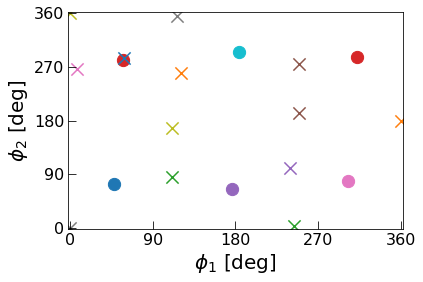

In [43]:
%%time
initial_solns = []
phi_eqs = []
already_found = False
for ig in inital_guesses:
    try:
        soln = newton_solve(ig,amd0,rtol = 1e-8,atol = 1e-13)
    except:
        continue
    phi1,phi2 = soln[:2]
    phi1,phi2=np.mod([phi1,phi2],2*np.pi)
    
    # Has this combinations of phi1 & phi2 occurred yet?
    if len(phi_eqs)>0:
        already_found = np.any(np.alltrue(np.isclose(np.array(phi_eqs),np.array((phi1,phi2))),axis=1))
    if not already_found:
        phi_eqs.append((phi1,phi2))
        jac = Dfun(soln,amd0)
        eigs = np.linalg.eigvals(jac)
        eigs_r = np.real(eigs)
        ell = np.alltrue(np.isclose(np.abs(eigs_r),0))
        # Save initial conditions for points at 
        # elliptic equilibria
        if ell:
            initial_solns.append(soln)
        mrker = 'o' if ell else 'x'
        plt.scatter(180 * phi1 / np.pi,180 * phi2 / np.pi,s=150,marker=mrker)
plt.xlim(-2,362)
plt.ylim(-2,362)
plt.xticks([0,90,180,270,360])
plt.yticks([0,90,180,270,360])
plt.tick_params(labelsize=16,size=8,direction='in')
plt.xlabel(r"$\phi_1$ [deg]",fontsize=20)
plt.ylabel(r"$\phi_2$ [deg]",fontsize=20)

# Get $N$-body simulations at equilibria

Let's create a canonical transformation representing the composition of all the transformations we've gone through so far. 
Used to go from equilibiria -> poincare variables -> N-body simulations

In [44]:
ct_composite = CanonicalTransformation.composite([ct,ct_rescale,ct_translate,ct_polar2cart])

Our `kam_rtc` Hamiltonian has a reduced phase space, owing to the conserved quantities we found along the way. We write a function to start from `kam_rtc.full_values`, corresponding to the full $6N$ dimensional phase space we started with. We then overwrite the dynamical variables in the reduced phase space (with indices specified by `active_mask`), as well as $\delta \Phi_4$, which we chose above as `amd0`. We then transform all those values back to our original Poincare variables through `ct_composite`, and turn it into a REBOUND simulation.

In [45]:
active_mask = np.array([v in kam_rtc.qp_vars for v in kam_rtc.full_qp_vars])
idPhi4 = kam_rtc.full_qp_vars.index(dPhi[3])

# Convert a solution to a rebound simulation
def to_sim(soln,amdval,sim0):
    vals = np.array(kam_rtc.full_values)
    vals[active_mask] = soln
    vals[idPhi4] = -1*amdval
    pvars = Poincare.from_Simulation(sim0)
    pvars.values = ct_composite.new_to_old_array(vals)
    sim = pvars.to_Simulation()
    sim.t = 0
    return sim
# Run a rebound simulation and get orbital angles and eccentricities
def get_angles_and_eccentricities(sim,times):
    N = len(times) 
    ps = sim.particles
    Npl = len(ps) - 1
    angs = np.zeros((N,3*Npl))
    eccs = np.zeros((N,Npl))
    for i,t in enumerate(times):
        sim.integrate(t)
        for j,p in enumerate(ps[1:]):
            eccs[i,j] = p.e
            angs[i,j] = p.l
            angs[i,j+Npl] = -1 * p.pomega
            angs[i,j+2*Npl] = -1 * p.Omega
    return angs,eccs

We now plot 6 integrations, for each of the 6 stable equilibria.

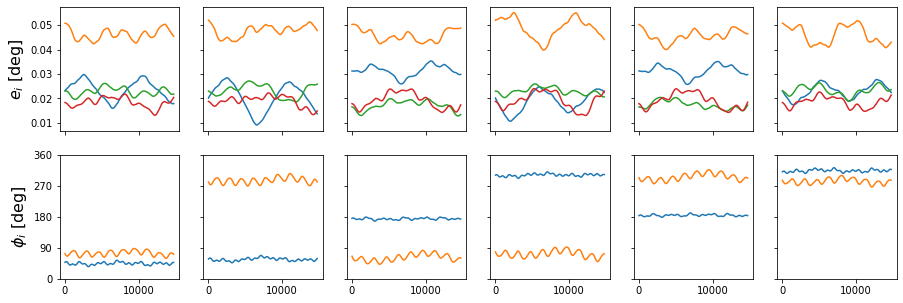

In [46]:
# Simulation times to get N-body results for
times = np.linspace(0,1,256) * 2e3 * sim.particles[1].P

# Set up plots
fig,ax = plt.subplots(2,6,figsize=(15,5),sharex=True,sharey='row')

# Loop over 6 stable equilibria, plot N-body solutions
for i,soln in enumerate(initial_solns):
    sim = to_sim(soln,amd0,sim)
    angs,eccs = get_angles_and_eccentricities(sim,times)
    ax[0,i].plot(times,eccs)
    res_angs = np.mod(np.array([A @ ang for ang in angs]),2*np.pi)
    ax[1,i].plot(times,180*res_angs[:,0]/np.pi)
    ax[1,i].plot(times,180*res_angs[:,1]/np.pi)
    
# make things  prettier
ax[0,0].set_ylabel(r"$e_i$ [deg]",fontsize = 16)
ax[1,0].set_ylabel(r"$\phi_i$ [deg]",fontsize = 16)
ax[1,0].set_yticks([0,90,180,270,360])

# AMD-dependence of Period ratios and eccentricities 

For a given equilibrium solution (we'll take the one corresponding to the right-most panels above, which is the solution that Kepler 223 is closest to), we can also vary the system AMD (or equivalently $\delta \Phi_4$), and ask what eccentricities and deviations from resonance that corresponds to for each pair of planets in the system.

We choose to express each pair's deviation from resonance as $\Delta = \frac{j-1}{j}\frac{P_\mathrm{out}}{P_\mathrm{in}} - 1$.

In [47]:
init_soln = initial_solns[5]
phi1eq,phi2eq=np.mod(np.array(init_soln[:2]), 2*np.pi) * 180/np.pi
print("Using equilibrium with phi1={:.1f} deg, phi2={:.1f} deg".format(phi1eq,phi2eq))
# The actual Kepler-223 system resides close to this equilibrium

Using equilibrium with phi1=311.9 deg, phi2=286.8 deg


In [48]:
Nsolns = 150
amdvals = np.logspace(np.log10(0.05 * amd0),np.log10(25*amd0),Nsolns)
guess = init_soln.copy()
eq_solns = np.zeros((Nsolns,guess.shape[0]))
for i,amdval in enumerate(amdvals):
    guess = newton_solve(guess,amdval)
    eq_solns[i] = guess

For example, a particular value of the AMD might correspond to, say, $\Delta_{bc} = 0.04$ in the top panel, from which we could read off each planet's corresponding eccentricity. For that particular value of eccentricity for planet $c$, we could then find that value of $e_c$ in the middle panel, and read off $e_d$ and the deviation from resonance for the $cd$ planet pair ($\Delta_{cd}$). And similarly we could take that value of $e_d$ to find the corresponding $e_e$ in the bottom panel and $\Delta_{de}$.

Text(0.5, 0, '$100\\times\\Delta$')

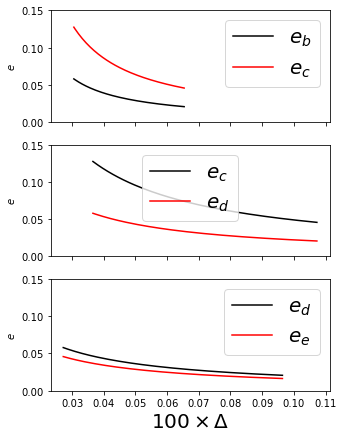

In [49]:
plstr='bcde'
fig,ax = plt.subplots(3,sharex=True,figsize=(5,7))
periods,eccs = np.zeros((2,len(eq_solns),4))
for i,soln in enumerate(eq_solns):
    sim = to_sim(soln,amdvals[i],sim)
    ps = sim.particles
    periods[i] = [p.P for p in ps[1:]]
    eccs[i] = [p.e for p in ps[1:]]
Deltas = periods[:,1:]/periods[:,:-1] * np.array([3/4,2/3,3/4])-1
for j,D in enumerate(Deltas.T):
    ax[j].plot(100*D,eccs[:,j],'k',label="$e_{}$".format(plstr[j]))
    ax[j].plot(100*D,eccs[:,j+1],'r',label="$e_{}$".format(plstr[j+1]))
    ax[j].legend(fontsize=20)
    ax[j].set_ylim(0,0.15)
    ax[j].set_ylabel("$e$")
ax[2].set_xlabel(r"$100\times\Delta$",fontsize=20)